### Project 1 — End-to-End ML Workflow 

This notebook orchestrates the full classification workflow:

1) **Load & Preprocess & Train/Val/Test Splits** 

2) **Model Showcases**  

3) **Evaluation**  
---

In [1]:
# set working directory to project root
import os
os.chdir("..")  # or full path to project root
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.preprocess import DataHandler
from scripts.perceptron_model import Perceptron
from scripts.adalinesgd_model import AdalineSGD
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

#### Preprocessing:

In [2]:
# read in data
data_handler = DataHandler()
data_handler.load_data_into_class(file_path="data/project_adult.csv")

# split into train and test
X_train, X_test, y_train, y_test = data_handler.split_data(target_column="income", filepath="data/project_adult.csv")

# preprocess the data
X_train_processed = data_handler.preprocess_set(X_train, train_or_test="train")
X_test_processed = data_handler.preprocess_set(X_test, train_or_test="test")

#### Training Perceptron and Adaline:

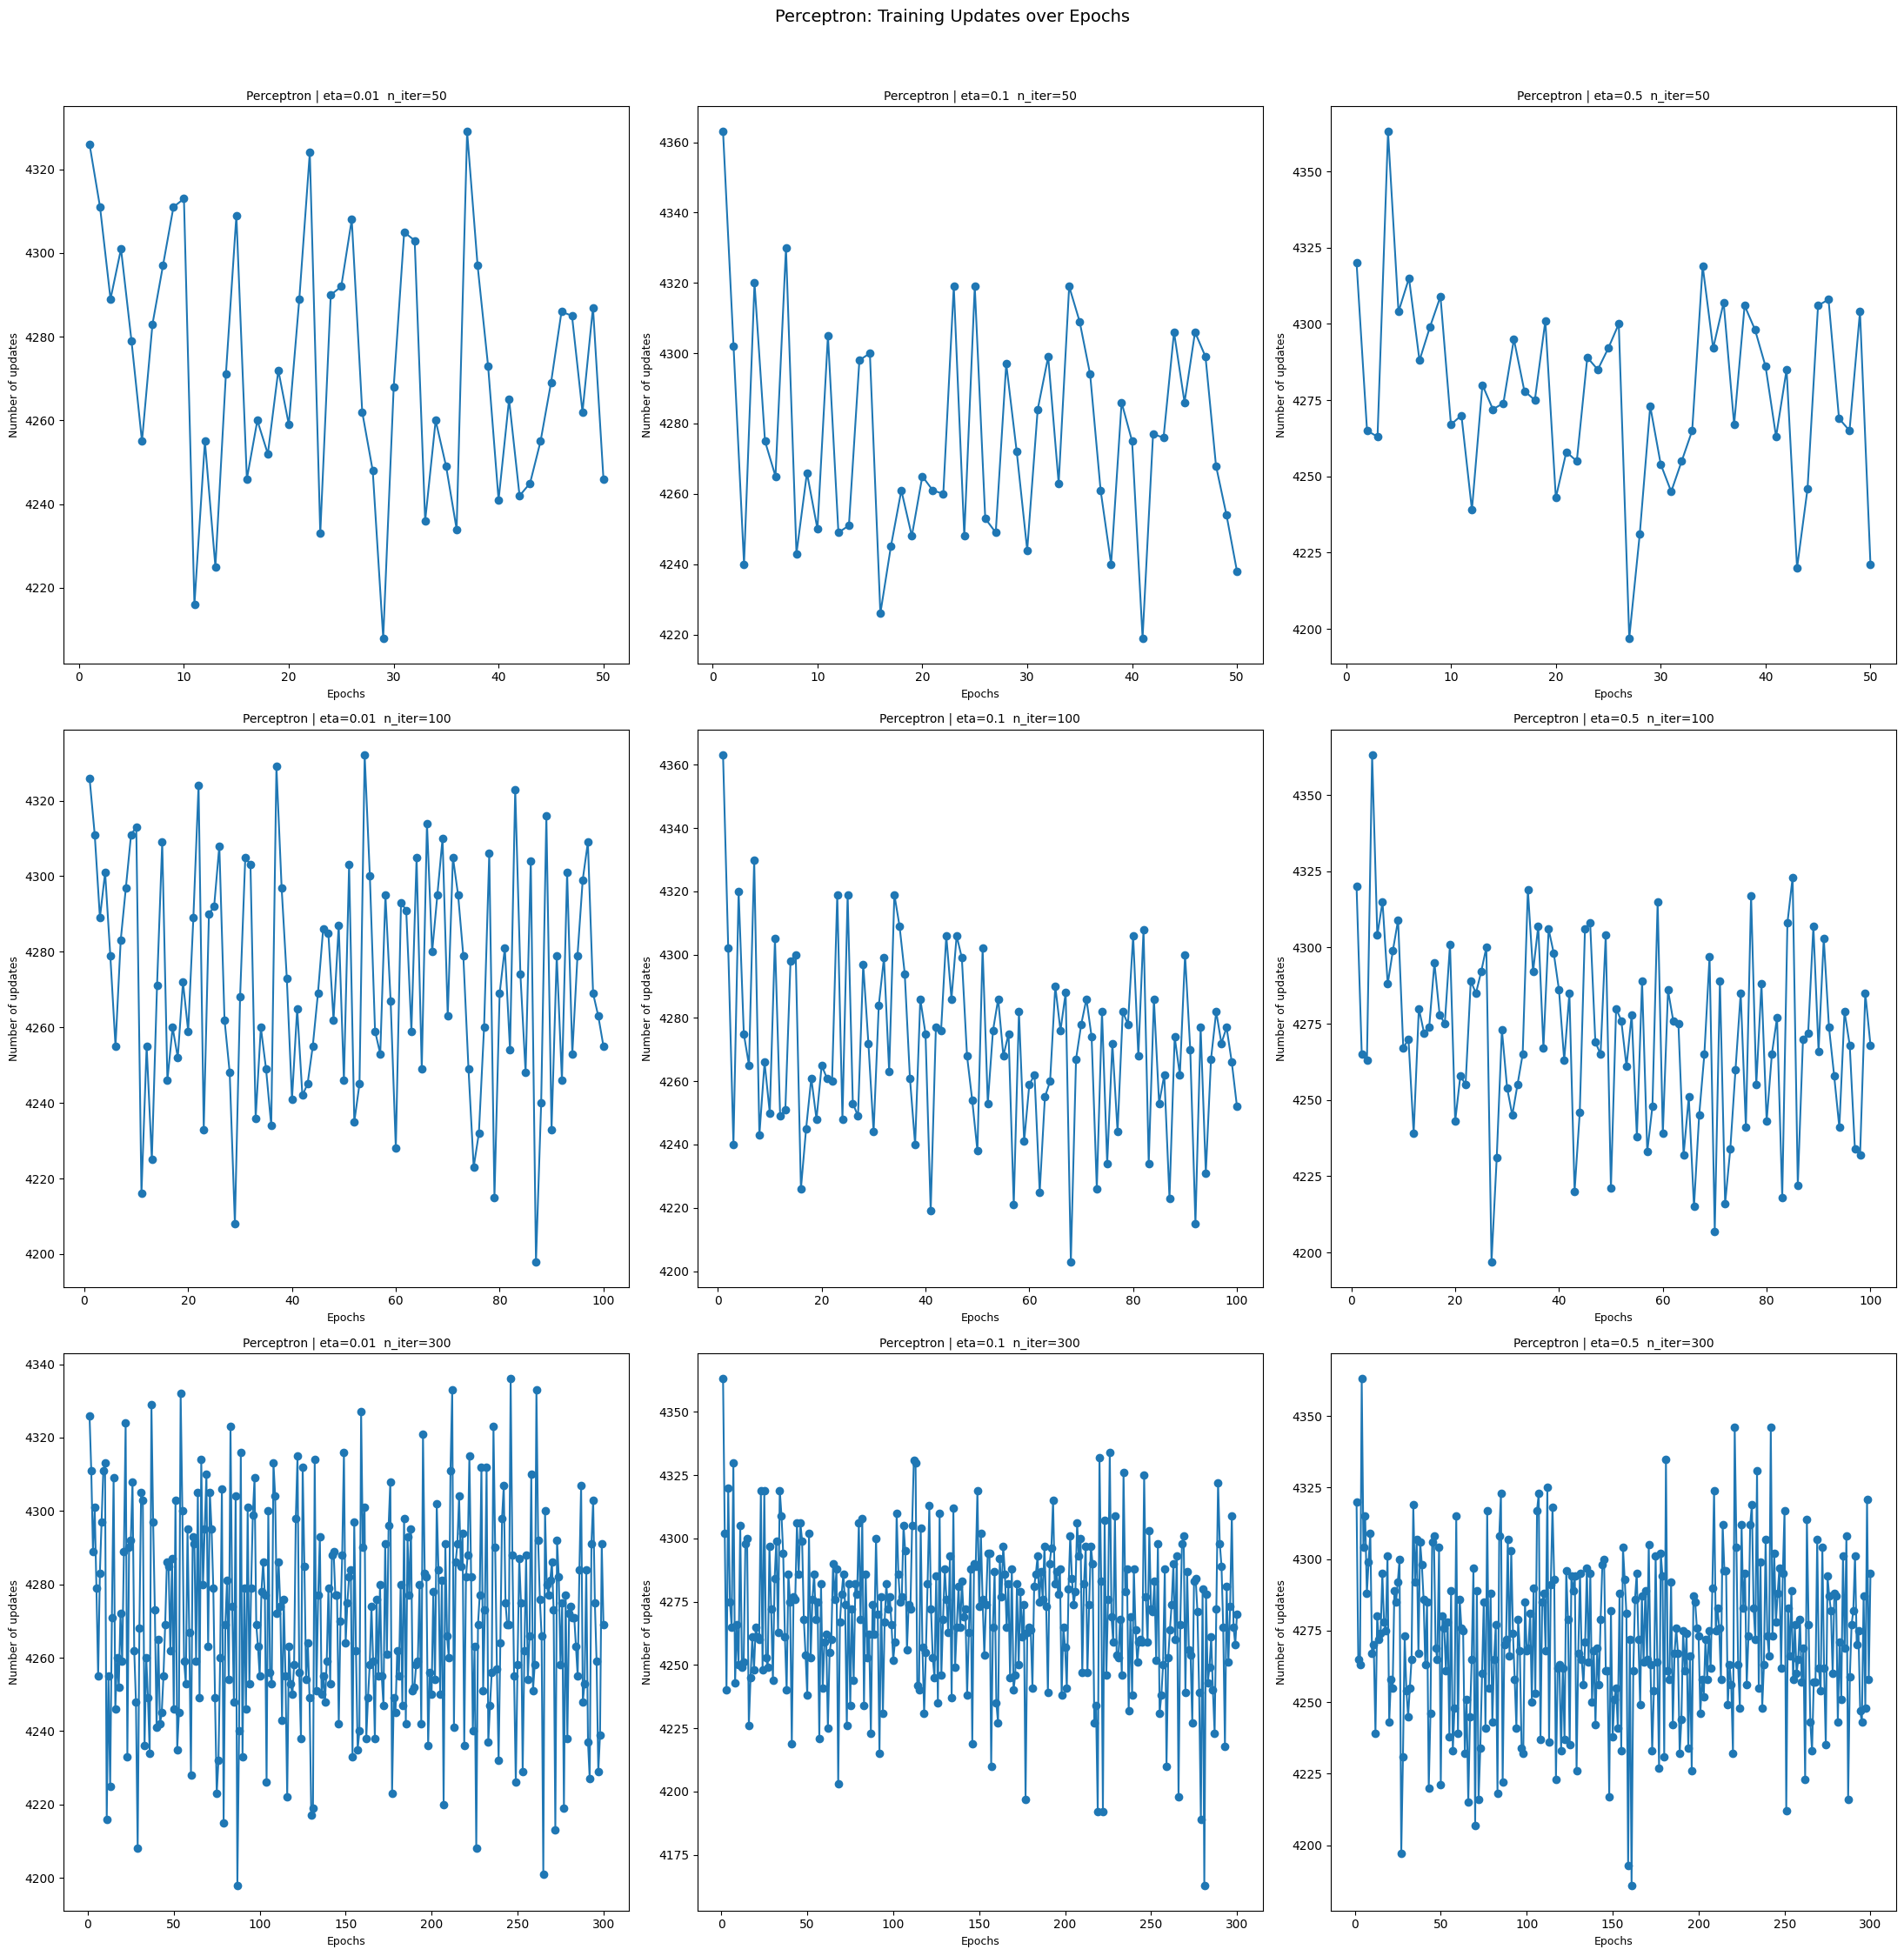

Perceptron best config: {'eta': 0.5, 'n_iter': 50} score: 4221


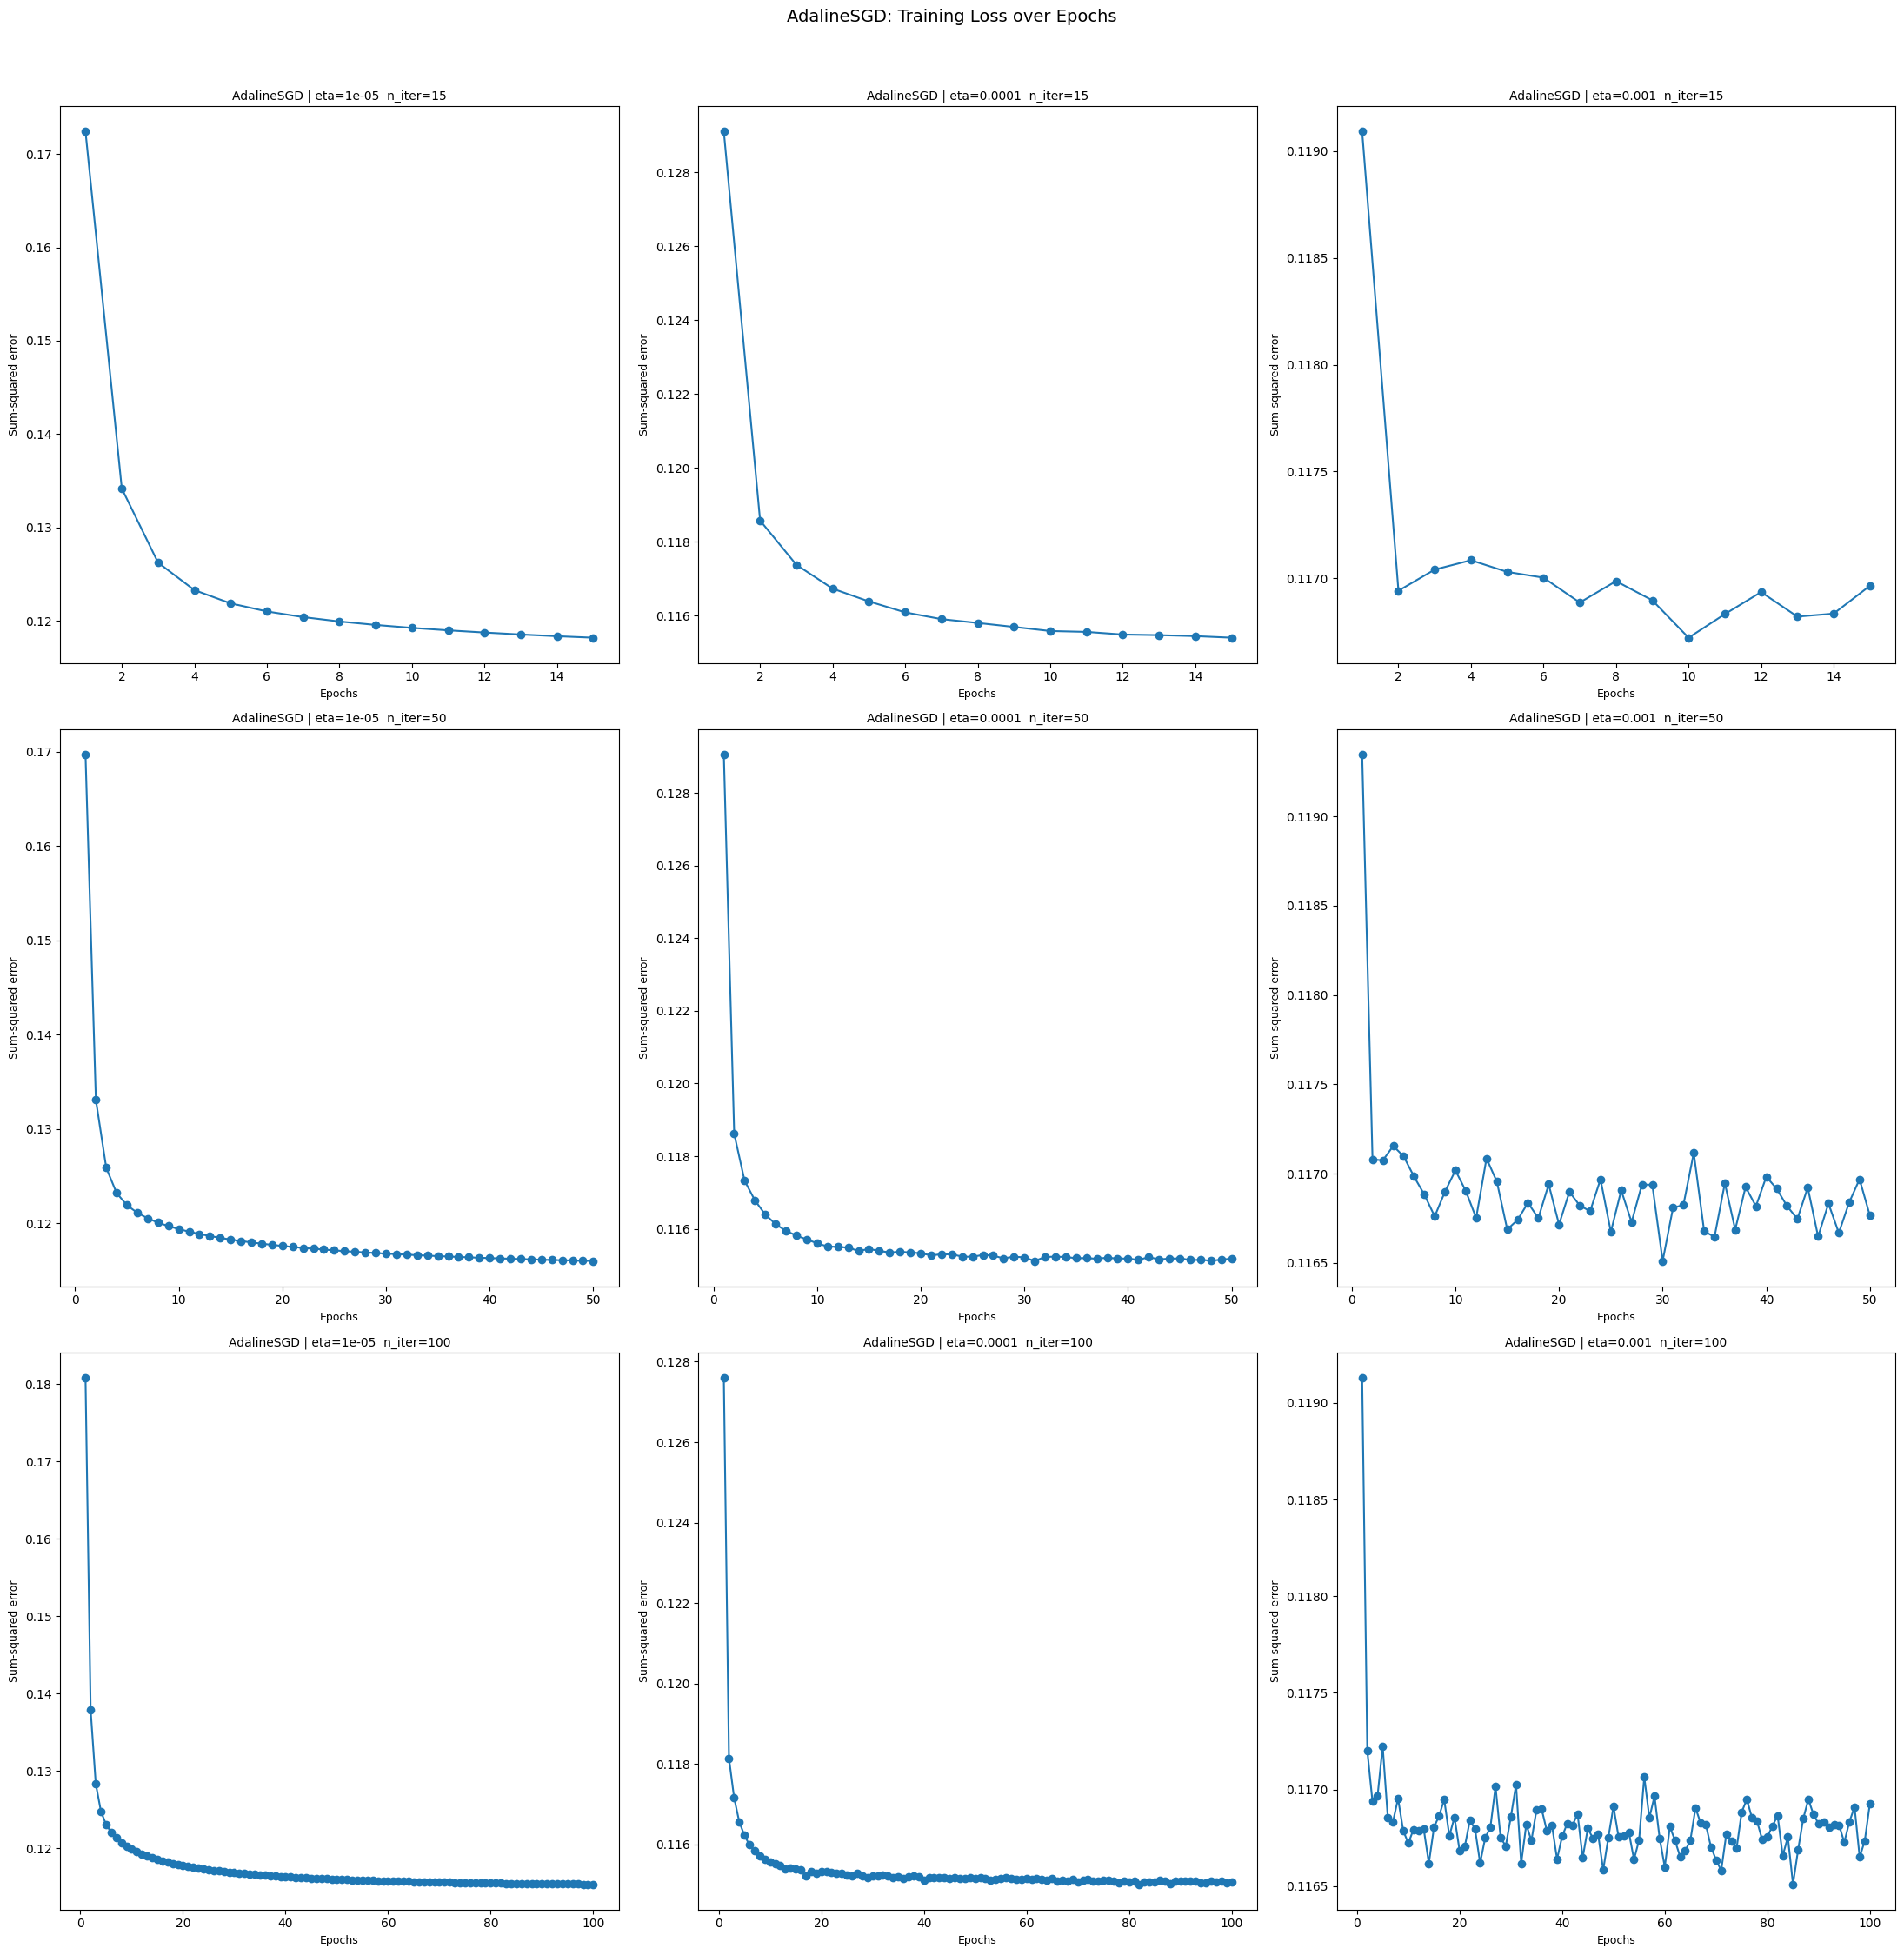

Adaline best config: {'eta': 0.0001, 'n_iter': 100} score: 0.11507491604948533


In [3]:
# handbuilt perceptron and adaline models require data of different shape (numpy arrays)
X_train_perceptron = X_train_processed.values
y_train_perceptron = (y_train == ">50K").astype(int).values

# initialize perceptron and adaline models. iterate through learning rates and iterations to find best hyperparameters
perceptron_eta_list = [0.01, 0.1, 0.5]
perceptron_max_iter_list = [50, 100, 300]

adaline_eta_list = [1e-5, 0.0001, 0.001]
adaline_max_iter_list = [15, 50, 100]

# PERCEPTRON
fig, ax = plt.subplots(nrows=len(perceptron_max_iter_list), ncols=len(perceptron_eta_list), figsize=(22, 22))
best_ppn_score, best_ppn_cfg = np.inf, None
for r, n_iter in enumerate(perceptron_max_iter_list):
    for c, eta in enumerate(perceptron_eta_list):
        ppn = Perceptron(n_iter=n_iter, eta=eta)  # add shuffle/random_state if supported
        ppn.fit(X_train_perceptron, y_train_perceptron)
        hist = getattr(ppn, "errors_", [])
        if len(hist) > 0:
            ax[r, c].plot(range(1, len(hist)+1), hist, marker='o')
            last = hist[-1]
            if last < best_ppn_score:
                best_ppn_score, best_ppn_cfg = last, {"eta": eta, "n_iter": n_iter}
        ax[r, c].set_xlabel("Epochs", fontsize=9)
        ax[r, c].set_ylabel("Number of updates", fontsize=9)
        ax[r, c].set_title(f"Perceptron | eta={eta}  n_iter={n_iter}", fontsize=10)

fig.suptitle("Perceptron: Training Updates over Epochs", fontsize=14, y=1.02)
fig.tight_layout()
plt.show()
print("Perceptron best config:", best_ppn_cfg, "score:", best_ppn_score)

# ADALINE (SGD)
fig, ax = plt.subplots(nrows=len(adaline_max_iter_list), ncols=len(adaline_eta_list), figsize=(22, 22))
best_ada_score, best_ada_cfg = np.inf, None
for r, n_iter in enumerate(adaline_max_iter_list):
    for c, eta in enumerate(adaline_eta_list):
        ada = AdalineSGD(n_iter=n_iter, eta=eta)  # add shuffle/random_state if supported
        ada.fit(X_train_perceptron, y_train_perceptron)
        hist = getattr(ada, "losses_", [])
        if len(hist) > 0:
            ax[r, c].plot(range(1, len(hist)+1), hist, marker='o')
            last = hist[-1]
            if last < best_ada_score:
                best_ada_score, best_ada_cfg = last, {"eta": eta, "n_iter": n_iter}
        ax[r, c].set_xlabel("Epochs", fontsize=9)
        ax[r, c].set_ylabel("Sum-squared error", fontsize=9)
        ax[r, c].set_title(f"AdalineSGD | eta={eta}  n_iter={n_iter}", fontsize=10)

fig.suptitle("AdalineSGD: Training Loss over Epochs", fontsize=14, y=1.02)
fig.tight_layout()
plt.show()
print("Adaline best config:", best_ada_cfg, "score:", best_ada_score)

#### Evaluate adaline and perceptron models:

In [4]:
# create y test sets for both models
y_test_perceptron = (y_test == ">50K").astype(int).values

# predict on test set with best models (perceptron)
best_ppn = Perceptron(eta=0.5, n_iter=50, random_state=42)
best_ppn.fit(X_train_perceptron, y_train_perceptron)
ppn_test_preds = best_ppn.predict(X_test_processed.values)

# (adaline)
best_adaline = AdalineSGD(eta=0.0001, n_iter=100, random_state=42)
best_adaline.fit(X_train_perceptron, y_train_perceptron)
ada_test_preds = best_adaline.predict(X_test_processed.values)

# evaluate results
ppn_accuracy = np.mean(ppn_test_preds == y_test_perceptron)
ada_accuracy = np.mean(ada_test_preds == y_test_perceptron)

# print results
print(f"Perceptron Test Accuracy: {ppn_accuracy:.4f}")
print(f"AdalineSGD Test Accuracy: {ada_accuracy:.4f}")

Perceptron Test Accuracy: 0.7476
AdalineSGD Test Accuracy: 0.8347


#### Predict project validation inputs:

In [5]:
# preprocess data for project validation set
data_handler.load_data_into_class(file_path="data/project_validation_inputs.csv")
validation_data_set = data_handler.pop_dataset_from_class(file_path="data/project_validation_inputs.csv")
processed_validation_set = data_handler.preprocess_set(df=validation_data_set, train_or_test="test")

# predict on validation set with best models
perceptron_validation_preds = best_ppn.predict(processed_validation_set.values)
adaline_validation_preds = best_adaline.predict(processed_validation_set.values)

# print results
np.set_printoptions(threshold=1000000)   # show entire array
print("Perceptron Validation Predictions:", perceptron_validation_preds)
print("Adaline Validation Predictions:", adaline_validation_preds)

Perceptron Validation Predictions: [0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1
 1 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0
 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0
 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0
 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1
 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1
 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0
 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1
 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0
 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1
 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 

#### Implement sklearn versions of Perceptron and AdalineSGD:

In [ ]:
# fit sklearn models to our preprocessed data
sklearn_ppn = SklearnPerceptron(eta0=0.1, max_iter=50, random_state=42)
sklearn_adaline = SGDClassifier(loss='perceptron', eta0=0.0001, learning_rate='constant', max_iter=15, random_state=42)

# train sklearn models
sklearn_ppn.fit(X_train_processed, y_train)
sklearn_adaline.fit(X_train_processed, y_train)

# predict with sklearn models
sklearn_ppn_preds = sklearn_ppn.predict(X_test_processed)
sklearn_adaline_preds = sklearn_adaline.predict(X_test_processed)

# evaluate sklearn models
sklearn_ppn_accuracy = accuracy_score(y_test, sklearn_ppn_preds)
sklearn_adaline_accuracy = accuracy_score(y_test, sklearn_adaline_preds)

# print sklearn results
print(f"Sklearn Perceptron Test Accuracy: {sklearn_ppn_accuracy:.4f}")
print(f"Sklearn Adaline (SGD) Test Accuracy: {sklearn_adaline_accuracy:.4f}")

# write csvs
if not os.path.exists("data/outputs/Group_27_Perceptron_PredictedOutputs.csv"):
    np.savetxt("data/outputs/Group_27_Perceptron_PredictedOutputs.csv", sklearn_ppn_preds, delimiter=",", fmt='%s')
if not os.path.exists("data/outputs/Group_27_Adaline_PredictedOutputs.csv"):
    np.savetxt("data/outputs/Group_27_Adaline_PredictedOutputs.csv", sklearn_adaline_preds, delimiter=",", fmt='%s')

Sklearn Perceptron Test Accuracy: 0.7952
Sklearn Adaline (SGD) Test Accuracy: 0.8056
